# DEMIX Wine Contest notebook

notebook by Carlos H Grohmann (Univ. São Paulo, Brazil)  
version 2023-06-27

This notebook was developed within the DEMIX project  
(DEMIX: Digital Elevation Model Intercomparison eXperiment)  
more information here: https://ceos.org/ourwork/workinggroups/wgcv/current-activites/  

The notebook provides functions to run a 'Wine Contest' (or Randomized Complete Block Design (RCBD))  
to compare Global Digital Elevation Models (DEMs) as described in:  
Conrad et al, 2023....

The requirements to run this notebook are Python 3.10+, numpy, pandas, matplotlib, seaborn, json, scipy.  
qgrid is used to provide interactive visualizations/filtering of the DEMIX database.  

The notebook is a simple interface to the stats/plots functions in the demix_wine_functions.py file.  

If you decide to run it locally, you might need to adjust the paths to external files such as the CSV databases and Friedman tables.  

If you run this trhough Google Colab, you will need to fetch these auxiliary files and install a different version of qgrid (code provided below)

In [6]:
# run this to get cells as wide as your browser (optional, but really helps to visualize the dataframe)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### The next cell is only for Google Colab. Fetch files and install qgrid

In [1]:
## ONLY FOR GOOGLE COLAB
## get external files - Friedman tables, custom DEMIX functions and CSV files used for the analysis

## DEMIX database
# !wget https://zenodo.org/record/7402618/files/demix_database_v1.csv?download=1

## Friedman tables and custom functions
# !wget https://github.com/CarlosGrohmann/DEMIX_wine_contest/raw/main/Friedmans_tables.zip
# !unzip Friedmans_tables.zip
# !wget https://github.com/CarlosGrohmann/DEMIX_wine_contest/raw/main/demix_wine_functions.py 

## examples
# !wget https://github.com/CarlosGrohmann/DEMIX_wine_contest/raw/main/demix_dbase_hillshade_criterion.csv
# !wget https://github.com/CarlosGrohmann/DEMIX_wine_contest/raw/main/demix_dbase_toy_example.csv

## install qgrid, a version that works with Colab
# !pip install git+https://github.com/lukewys/qgrid.git

### Basics. Import libraries, etc

### IMPORTANT!
The notebook uses `qgrid` (https://github.com/quantopian/qgrid) to show the dataframe and to allow for interactive filtering.  
BUT... the qgrid module hasn't been updated in a few years so you might face some issues when running it with the latest ipywidgets version.

If you receive an error like "TypeError: register() missing 1 required positional argument: 'widget'"
One solution is to edit the file qgrid.py (look for YOUR_PYTHON_INSTALL/site-packages/qgrid/grid.py)
and change line 524 (https://github.com/jupyter-widgets/ipywidgets/issues/3031) from  

`@widgets.register()`  
to   
`@widgets.register`  

If qgrid imports without issues but is not showing the grid (table) widget, you need to enable it:  
     
`jupyter nbextension enable --py qgrid`  
`jupyter nbextension enable --py widgetsnbextension`

Then restart you notebook and it should work

In [1]:
# ------------------------------------------------------------------------------
# ---------------------------     IMPORTS      ---------------------------------
# ------------------------------------------------------------------------------
# imports - general
import sys,os
import itertools
import json
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy import stats
import qgrid
# pd.set_option("display.max_rows", None) # use with caution!

# import custom demix functions
sys.path.append('.')
import demix_wine_functions as dw
from IPython.display import display, HTML

# imports for google colab
# from google.colab import files
# from google.colab import output
# output.enable_custom_widget_manager()

#imports - plotting
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# ------------------------------------------------------------------------------
# set data directories
root_dir = '.'
tables_dir = f'{root_dir}/Friedmans_tables'

### Select CSV database file

In [2]:
# ------------------------------------------------------------------------------
# -------------------     SELECT CVS FILE      ---------------------------------
# ------------------------------------------------------------------------------

# comment / uncomment the line to select the database
csv_file = 'demix_database_v2.csv'
# csv_file = 'example_paper.csv'
# csv_file = 'demix_wine_contest_matrix_hillshade_criterion.csv'
# csv_file = 'demix_wine_contest_matrix_simple_example.csv'


selected_csv_file = [f'{root_dir}/{csv_file}']

# read CSV file, make dataframe with one criterion per row
df_criteria = dw.make_criteria_df(selected_csv_file)

# we use this to remove the '-9999' values that might come from voids (nodata)
df_criteria.replace({-9999: np.nan}, inplace=True)

# ------------------------------------------------------------------------------
# The dem_list variable is used all over the notebook
# crit_idx  = list(df_criteria.columns).index('CRITERION')
# dem_list  = list(df_criteria.columns)[crit_idx+1:]
dem_list = ['FABDEM', 'COP', 'ALOS', 'NASA', 'SRTM', 'ASTER']

# dem_list = ['FABDEM', 'COPDEM', 'ALOS', 'NASADEM', 'SRTM', 'ASTER']

### Define tolerances for criteria

In [3]:
# ------------------------------------------------------------------------------
# --------------------------------- TOLERANCES   -------------------------------
# ------------------------------------------------------------------------------
# define tolerances for each criterion

low_tolerance_dict = {'ELVD_AVD':0.5,'ELVD_STD':0.5,'ELVD_RMSE':0.5,'ELVD_MAE':0.5,'ELVD_LE90':0.5,
                      'RUFD_AVD':0.2,'RUFD_STD':0.2,'RUFD_RMSE':0.2,'RUFD_MAE':0.2,'RUFD_LE90':0.2,
                      'SLPD_AVD':0.5,'SLPD_STD':0.5,'SLPD_RMSE':0.5,'SLPD_MAE':0.5,'SLPD_LE90':0.5,
                      'Hillshade':0,}

high_tolerance_dict = {'ELVD_AVD':1.0,'ELVD_STD':1.0,'ELVD_RMSE':1.0,'ELVD_MAE':1.0,'ELVD_LE90':1.0,
                       'RUFD_AVD':0.4,'RUFD_STD':0.4,'RUFD_RMSE':0.4,'RUFD_MAE':0.4,'RUFD_LE90':0.4,
                       'SLPD_AVD':1.0,'SLPD_STD':1.0,'SLPD_RMSE':1.0,'SLPD_MAE':1.0,'SLPD_LE90':1.0,
                       'Hillshade':0,}

# tolerances as string, for plots
low_tolerance_str = 'LOW tolerances: \n' + json.dumps(low_tolerance_dict).replace(',',',\n')
high_tolerance_str = 'HIGH tolerances: \n' + json.dumps(high_tolerance_dict).replace(',',',\n')


# if you don't want to set any tolerance (i.e., set all to Zero),
# uncomment the "tolerance_dict = None" line and it will overwrite the values
# tolerance_dict = None


## Display Database with qgrid  

Any fieltring/selection made here will propagate to the next step

#### Here you MUST show the the database and select AT LEAST between DSM/DTM otherwise the comparison won't be correct

In [6]:
##################################################################
# display database with qgrid - this allows for interactive filtering
grid = qgrid.QGridWidget(df=df_criteria)
display(grid)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## The Wine Contest  

This is where the fun begins. The next cell will get the databse from qgrid (that is, any filtering will lead to a different result)  

You can play around with qgrid to select different combinations of DEMs or criteria and see how it will impact the final ranking

In [7]:
######################## WINE CONTEST ##########################
# here you can play around with the filters and see the differences in results

# get changed (or not) database from qgrid
df_for_ranking = grid.get_changed_df()

# define which tolerances should be used
tolerance_dict = low_tolerance_dict
    
# calculate ranks for metrics in database
df_ranks = dw.make_rank_df(df_for_ranking,dem_list,tolerance_dict,method='average')

# confidence level for friedman stats
CL = 0.05

# this will show the filters applied to the database
dw.show_filters(grid)

# run the Wine Contest over the database
df_wc_result,n,df_table,tie_dict = dw.wine_contest(df_ranks,dem_list,tables_dir,cl=CL,alpha=0.95,verbose=True)

Ranking with user-defined tolerances (might take a while...)

No filters applied

Results of the DEMIX Wine Contest

For k=6, CL=0.05, and N=39785, the critical value to compare is chi_crit=11.038
And since chi_r (124290.097) is greater than chi_crit (11.038)...
Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!



### Post-Hoc analysis
The final result of the Wine Contest is based on the table below.  

The columns are:  
**Rank** - ranks calculated from the second column  
**Sum of ranks** - the sum of individual ranks of the Opinions Table  
**Sum of ranks divided by number of opinions** - a 'normalized' Sum of Ranks, helps to see the real differences and compare results from different filterings/subsets  
**Ties with** - in case of ties, the DEM names will show up here



In [8]:
dw.wine_contest_results(df_wc_result)

,Rank,Sum of ranks,Sum of ranks divided by number of opinions,Ties with
COP,1.0,78089.0,1.963,
FABDEM,2.0,84397.5,2.121,
ALOS,3.0,118563.0,2.980,
NASA,4.0,163678.0,4.114,
SRTM,5.0,166471.5,4.184,
ASTER,6.0,224286.0,5.637,


# Figures
For the plots, we work with the initial, unfiltered database (df_criteria)
and make the selection of features by queries to the database

The cells below will reproduce some (not all) figures found in the article (and maybe some that didn't make the final cut).  

Please note that the plot options (symbols, colors, etc) are tailored for the 6 global DEMs used in the article.  
If you decide to change which DEMs are analysed, you will need to change also the plotting options here  
and things might break! 

In [3]:
# ------------------------------------------------------------------------------
# ---------------------------     PLOT OPTIONS     -----------------------------
# ------------------------------------------------------------------------------
# main options for plots (colors, symbols etc)

sns.set(style='white')

dem_order = ['ALOS','COP','FABDEM','NASA','SRTM','ASTER']
dem_order_rank = [i+'_rank' for i in dem_order]

dem_color = ['#E69F00','#56B4E9','#CC79A7','#009E73','#D55E00','#0072B2']
dem_clr_pltt = sns.color_palette(dem_color, len(dem_color))
palette = {
    'ALOS':'#E69F00',
    'COP':'#56B4E9',
    'FABDEM':'#CC79A7',
    'NASA': '#009E73',
    'SRTM':'#D55E00',
    'ASTER':'#0072B2',}

dem_clr_dict = dict(zip(dem_order, dem_color))
markers = ['o'] * len(dem_order)
dem_mrks = dict(zip(dem_order, markers))

crit_order = ['ELVD_AVD', 'ELVD_STD', 'ELVD_RMSE', 'ELVD_MAE', 'ELVD_LE90',
               'SLPD_AVD', 'SLPD_STD', 'SLPD_RMSE', 'SLPD_MAE', 'SLPD_LE90',
               'RUFD_AVD', 'RUFD_STD', 'RUFD_RMSE', 'RUFD_MAE', 'RUFD_LE90']

# order of test areas
tile_sort = ['norway', 'oxford', 'caen_fr', 'valonne_fr', 'trentino', 'vanoise_fr', 
             'pyrenees', 'ebro_delta', 'madrid', 'republican_river', 'canyon_range', 
             'redwoods', 'shenandoah', 'blackwater', 'chincoteague', 'almeria', 
             'state_line', 'charleston', 'new_orleans', 'canary_east', 'la_palma', 
             'pernambuco', 'la_reunion_fr', 'sao_paolo', 'uruguay']

# symbols
symbols = ['X','o','s','^','v','d']


In [5]:
# unfiltered database
# df_for_ranking = df_criteria.copy()df_criteria.copy().query(cond)
df_for_ranking = df_criteria.copy()#.query(cond) # only non-us areas

# calculate ranks for metrics in database, with low and high tolerances
df_ranks_lt = dw.make_rank_df(df_for_ranking,dem_list,low_tolerance_dict,method='average')
df_ranks_ht = dw.make_rank_df(df_for_ranking,dem_list,high_tolerance_dict,method='average')

# # sort values by latitude
# df_lt_sort = df_ranks_lt.sort_values(by='AREA', key=lambda column: column.map(lambda e: tile_sort.index(e)))
# df_ht_sort = df_ranks_ht.sort_values(by='AREA', key=lambda column: column.map(lambda e: tile_sort.index(e)))

Ranking with user-defined tolerances (might take a while...)

Ranking with user-defined tolerances (might take a while...)



## Wine Contest based on single condition

In [7]:
#condition = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION=='{crit}'" for crit in crit_list2]
CL = 0.05
ref = 'DSM'
crit = 'ELVD_AVD'
condition = f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION=='{crit}'" #for crit in crit_list2]
df_ranks = df_ranks_lt

dw.single_condition_mwc(df_ranks,condition,dem_list,tables_dir,cl=CL)


Results of the DEMIX Wine Contest

For k=6, CL=0.05, and N=134, the critical value to compare is chi_crit=11.038
And since chi_r (556.919) is greater than chi_crit (11.038)...
Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!



,Rank,Sum of ranks,Sum of ranks divided by number of opinions,Ties with
COP,1.0,205.0,1.530,
FABDEM,2.0,315.0,2.351,ALOS
ALOS,3.0,354.5,2.646,FABDEM
NASA,4.5,573.5,4.280,SRTM
SRTM,4.5,573.5,4.280,NASA
ASTER,6.0,792.5,5.914,


## Bar plot of criteria for 2 tiles

In [5]:
csv = f'{root_dir}/{csv_file}'
df = pd.read_csv(csv, sep=',',engine='python',comment='#',quotechar='"')
df = df[['AREA','DEMIX_TILE','REF_TYPE','CRITERION','LAND_TYPE','TOLERANCE','ALOS','COP','FABDEM','NASA','SRTM','ASTER']]

ref = 'DTM'
tiles_list = ['N35VW116G','N28XW018B']
crit_list = ['ELVD_RMSE','ELVD_LE90','SLPD_RMSE','SLPD_MAE','RUFD_RMSE','RUFD_AVD']

# elv_crit = ['ELVD_MEAN','ELVD_MED','ELVD_AVD','ELVD_STD','ELVD_MAE','ELVD_RMSE','ELVD_LE90']
# slp_crit = ['SLPD_MEAN','SLPD_MED','SLPD_AVD','SLPD_STD','SLPD_MAE','SLPD_RMSE','SLPD_LE90']
# ruf_crit = ['RUFD_MEAN','RUFD_MED','RUFD_AVD','RUFD_STD','RUFD_MAE','RUFD_RMSE','RUFD_LE90']

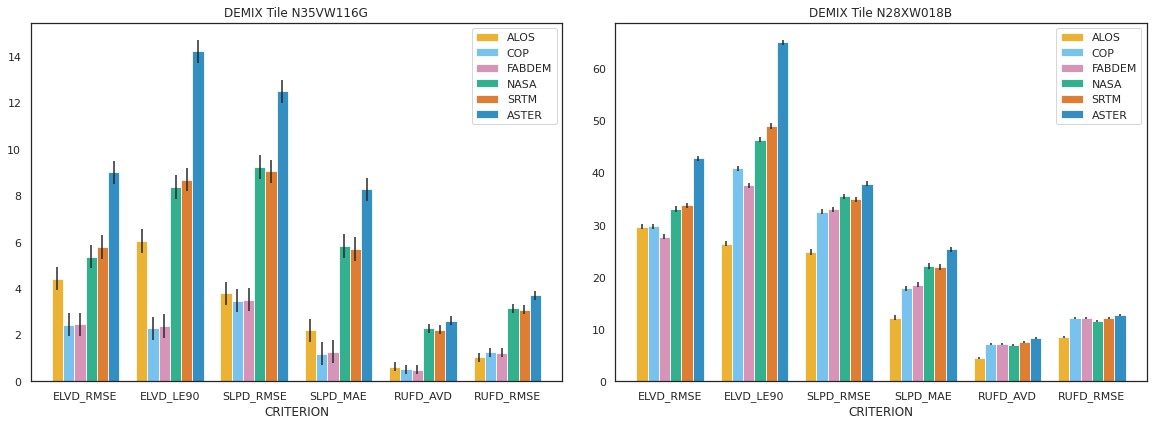

In [8]:
def plot_bars_2tiles(df, tiles_list, crit_list, fname):
    grid_kws = {'width_ratios': (0.48, 0.48), 'wspace': 0.1} # size of subplots
    fig, axes = plt.subplots(1, 2, gridspec_kw=grid_kws,figsize=(20,6.6))#, sharey='row')
    #---------------------------------------
    ref = 'DTM'
    for i in [0,1]:
        ax=axes[i]
        tile = tiles_list[i]
        cond = f"DEMIX_TILE=='{tile}' and REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION in {crit_list}"
        ax.set_title(f'DEMIX Tile {tile}')
        df_cond = df.query(cond).copy().set_index('CRITERION')
        df_cond.plot(ax=ax,kind='bar',yerr='TOLERANCE',color=palette,alpha=0.8,rot=0,width=0.8)
    # save fig
    if fname:
        plt.savefig(fname, dpi=300) 
    
fname = '2tiles_barplot_2023-06.svg'
plot_bars_2tiles(df, tiles_list, crit_list, fname=fname)



## WineContest rank of DEM per condition

In [12]:
def make_conditions_for_scatterplot(df):
    '''this is jut to make the string conditions for further
    querying of the dataframes. used to make the scatterplot with
    values and rectangles for ties'''

    # list of criteria for queries
    crit_list1 = ['FLAT','GENTLE','STEEP','CLIFF','BARREN','URBAN','FOREST']  
    crit_list2 = ['ELVD_AVD', 'ELVD_STD', 'ELVD_RMSE', 'ELVD_MAE', 'ELVD_LE90',
                  'SLPD_AVD', 'SLPD_STD', 'SLPD_RMSE', 'SLPD_MAE', 'SLPD_LE90',
                  'RUFD_AVD', 'RUFD_STD', 'RUFD_RMSE', 'RUFD_MAE', 'RUFD_LE90']
    crit_list3 = [f'RELIEF >= 500',
                  f'AVG_SLOPE < 18',
                  f'AVG_SLOPE >= 18',
                  f'AVG_ROUGH >= 10',
                  f'AVG_ROUGH < 5',
                  f'FOREST_PC >= 50',
                  f'URBAN_PC >= 25']
    
    # ---------- DSM + DTM ----------
    ref_list = ['DSM','DTM']      
    cond_list1 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL'" for ref in ref_list]
    label_list1 = [f'{ref} - ALL' for ref in ref_list]
    
    # ---------- DSM ----------
    ref='DSM'
    # condition 1
    cond_list2 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='{crit}'" for crit in crit_list1]
    label_list2 = [f'{ref} - {crit}' for crit in crit_list1]
    
    # condition 2
    cond_list3 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION=='{crit}'" for crit in crit_list2]
    label_list3 = [f'{ref} - ALL pixels - {crit}' for crit in crit_list2]
    
    # condition 3
    cond_list4 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and {crit}" for crit in crit_list3]
    label_list4 = [f'{ref} - ALL pixels - {crit}' for crit in crit_list3]
    

    # ---------- DTM ----------
    ref='DTM'
    # condition 1
    cond_list5 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='{crit}'" for crit in crit_list1]
    label_list5 = [f'{ref} - {crit}' for crit in crit_list1]
    
    # condition 2
    cond_list6 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION=='{crit}'" for crit in crit_list2]
    label_list6 = [f'{ref} - ALL pixels - {crit}' for crit in crit_list2]
    
    # condition 3
    cond_list7 = [f"REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and {crit}" for crit in crit_list3]
    label_list7 = [f'{ref} - ALL pixels - {crit}' for crit in crit_list3]
    
    # concat conditions and labels lists
    cond_list = cond_list1 + cond_list2 + cond_list3 + cond_list4 + cond_list5 + cond_list6 + cond_list7
    label_list = label_list1 + label_list2 + label_list3 + label_list4 + label_list5 + label_list6 + label_list7
    
    return cond_list,label_list

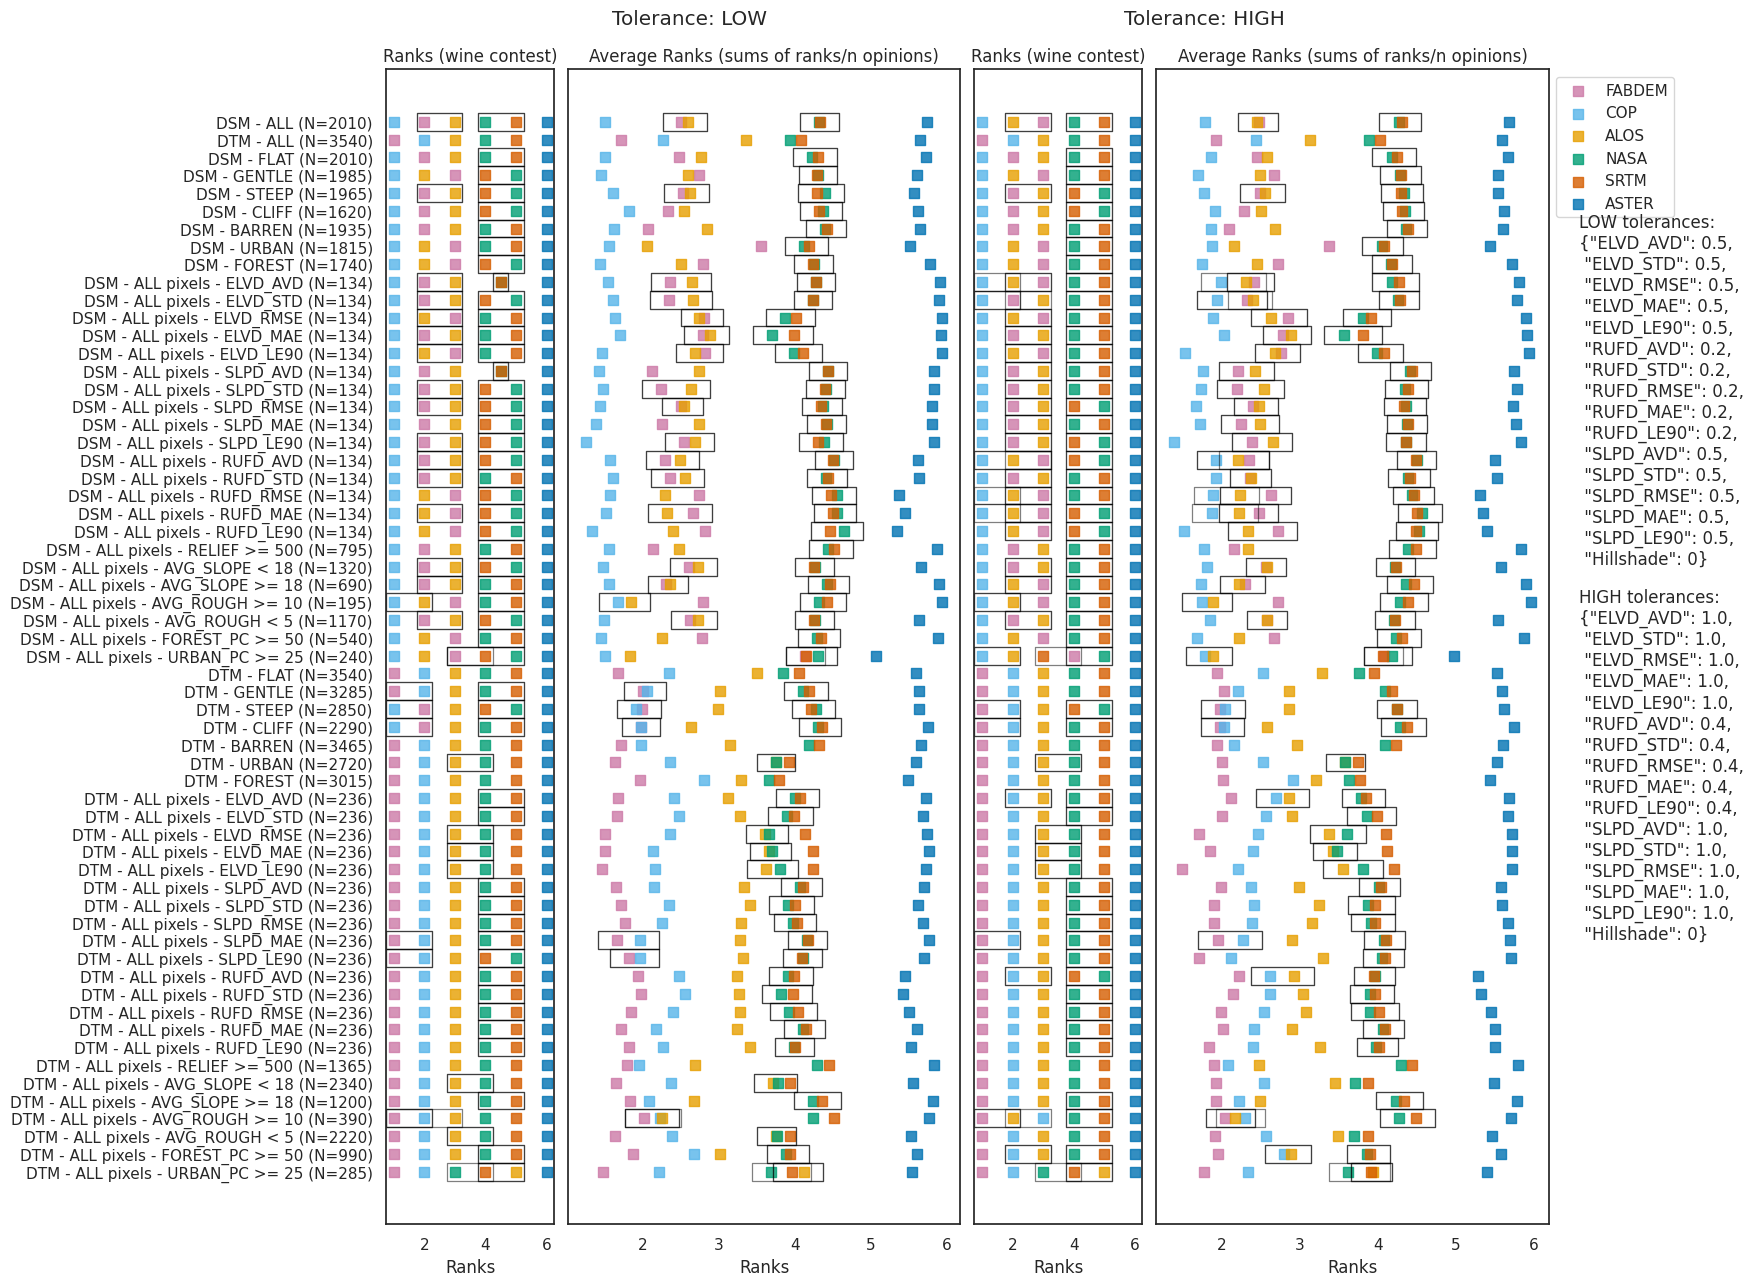

In [13]:
# confidence level for friedman stats
CL = 0.05

cond_list_lt,label_list_lt = make_conditions_for_scatterplot(df_ranks_lt)
cond_list_ht,label_list_ht = make_conditions_for_scatterplot(df_ranks_ht)

# ---------------------
# get data for plots
# low tolerance
df_plot1 = dw.get_winecontest_ranks_by_condition(df_ranks_lt,cond_list_lt,label_list_lt,dem_list,tables_dir,rnk_col='rank',cl=CL)
df_plot2 = dw.get_winecontest_ranks_by_condition(df_ranks_lt,cond_list_lt,label_list_lt,dem_list,tables_dir,rnk_col='sum_rnks_div_n',cl=CL)
# high tolerance
df_plot3 = dw.get_winecontest_ranks_by_condition(df_ranks_ht,cond_list_ht,label_list_ht,dem_list,tables_dir,rnk_col='rank',cl=CL)
df_plot4 = dw.get_winecontest_ranks_by_condition(df_ranks_ht,cond_list_ht,label_list_ht,dem_list,tables_dir,rnk_col='sum_rnks_div_n',cl=CL)

# define df and order of rows for plotting
df1 = df_plot1[::-1]
df2 = df_plot2[::-1]
df3 = df_plot3[::-1]
df4 = df_plot4[::-1]

# rectangles for ties
rects1 = dw.get_wc_ties_rects_by_condition(df_ranks_lt,cond_list_lt,dem_list,tables_dir,label_list_lt,cl=CL,rnk_col='rank')
pc1 = dw.ties_rectangles(rects1,df1)
rects2 = dw.get_wc_ties_rects_by_condition(df_ranks_lt,cond_list_lt,dem_list,tables_dir,label_list_lt,cl=CL,rnk_col='sum_rnks_div_n')
pc2 = dw.ties_rectangles(rects2,df2)
rects3 = dw.get_wc_ties_rects_by_condition(df_ranks_ht,cond_list_ht,dem_list,tables_dir,label_list_ht,cl=CL,rnk_col='rank')
pc3 = dw.ties_rectangles(rects3,df3)
rects4 = dw.get_wc_ties_rects_by_condition(df_ranks_ht,cond_list_ht,dem_list,tables_dir,label_list_ht,cl=CL,rnk_col='sum_rnks_div_n')
pc4 = dw.ties_rectangles(rects4,df4)


# ---------------------
# plot
grid_kws = {'width_ratios': (0.15, 0.35, 0.15, 0.35), 'wspace': 0.05} # size of subplots
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, gridspec_kw=grid_kws,figsize=(15,15),sharey=True)

for dem,s in zip(dem_list,symbols):
    ax1.scatter(y=df1.index, x=df1[dem], label=dem, marker='s', s=50, alpha=0.8, c=dem_clr_dict[dem])

for dem,s in zip(dem_list,symbols):
    ax2.scatter(y=df2.index, x=df2[dem], label=dem, marker='s', s=50, alpha=0.8, c=dem_clr_dict[dem])

for dem,s in zip(dem_list,symbols):
    ax3.scatter(y=df3.index, x=df3[dem], label=dem, marker='s', s=50, alpha=0.8, c=dem_clr_dict[dem])
    
for dem,s in zip(dem_list,symbols):
    ax4.scatter(y=df4.index, x=df4[dem], label=dem, marker='s', s=50, alpha=0.8, c=dem_clr_dict[dem])

ax1.add_collection(pc1)
ax2.add_collection(pc2)
ax3.add_collection(pc3)
ax4.add_collection(pc4)

# decorations
# fig.suptitle('Low Tolerance', fontdict={'size':16})
ax1.set_title('Ranks (wine contest)', fontdict={'size':12})
ax1.set_xlabel('Ranks')
ax2.set_title('Average Ranks (sums of ranks/n opinions)', fontdict={'size':12})
ax2.set_xlabel('Ranks')
ax3.set_title('Ranks (wine contest)', fontdict={'size':12})
ax3.set_xlabel('Ranks')
ax4.set_title('Average Ranks (sums of ranks/n opinions)', fontdict={'size':12})
ax4.set_xlabel('Ranks')
ax1.set_yticks(df1.index)
ax4.legend(bbox_to_anchor=(1.0,1.0))

# texts
low_tolerance_str = 'LOW tolerances: \n' + json.dumps(low_tolerance_dict).replace(',',',\n')
high_tolerance_str = 'HIGH tolerances: \n' + json.dumps(high_tolerance_dict).replace(',',',\n')

plt.suptitle(f'Tolerance: LOW                                                        Tolerance: HIGH', y=0.92)
fig.text(0.92,0.55,low_tolerance_str)
fig.text(0.92,0.30,high_tolerance_str)
plt.savefig('wc_average_ranks_lt_ht_2023-06.svg', dpi=300) # uncomment to save. Extension determines filetype
plt.show()



 

## Plot of means and medians

In [33]:
# re-read the demix database and sort by area
csv_means = f'{root_dir}/{csv_file}'
df = pd.read_csv(csv_means, sep=',',engine='python',comment='#',quotechar='"')
df = df[['AREA','REF_TYPE','LAND_TYPE','CRITERION', 'FABDEM', 'COP', 'ALOS', 'NASA','SRTM', 'ASTER']]
# df_sort = df.sort_values(by='AREA', key=lambda column: column.map(lambda e: tile_sort.index(e)))

medians = ['ELVD_MED','SLPD_MED','RUFD_MED']
means = ['ELVD_MEAN','SLPD_MEAN','RUFD_MEAN']
ref_lst = ['DSM','DTM']
ref_medians = [(x,y) for x in ref_lst for y in medians] # or list(itertools.product(ref_lst, medians))
ref_means = [(x,y) for x in ref_lst for y in means] 

In [36]:
# select only ALL landtypesm then groupby and get means
df_cond = df.query(f"LAND_TYPE=='ALL'").copy() 
df_group = df_cond.groupby(['AREA','REF_TYPE','CRITERION']).mean()
df_sort = df_group.sort_values(by='AREA', key=lambda column: column.map(lambda e: tile_sort.index(e)))
df_sort

FABDEM       COP      ALOS      NASA      SRTM  \
AREA    REF_TYPE CRITERION                                                     
norway  DTM      RUFD_MEAN -1.643333 -0.080000 -0.094444 -2.291111 -2.301111   
                 ELVD_MAE   3.051111  4.250000  5.353333  5.757778  5.483333   
                 ELVD_MEAN -0.644444  3.675556  5.120000  5.477778  5.143333   
                 ELVD_MED  -0.867778  2.164444  4.031111  4.775556  4.435556   
                 ELVD_RMSE  4.277778  6.182222  7.021111  7.155556  6.920000   
...                              ...       ...       ...       ...       ...   
uruguay DTM      SLPD_MEAN -0.380000 -0.060000  0.410000  0.240000  0.330000   
                 SLPD_MED  -0.280000 -0.010000  0.310000  0.370000  0.440000   
                 SLPD_RMSE  1.170000  1.100000  2.650000  3.490000  3.520000   
                 ELVD_LE90  1.170000  1.050000  2.980000  3.310000  4.530000   
                 ELVD_AVD   0.460000  0.420000  1.100000  1.600000  1.620000   

                                ASTER  
AREA    REF_TYPE CRITERION             
norway  DTM      RUFD_MEAN   0.214444  
                 ELVD_MAE    6.802222  
                 ELVD_MEAN   0.605556  
                 ELVD_MED    0.523333  
                 ELVD_RMSE   8.890000  
...                               ...  
uruguay DTM      SLPD_MEAN   3.710000  
                 SLPD_MED    3.440000  
                 SLPD_RMSE   7.390000  
                 ELVD_LE90  14.590000  
                 ELVD_AVD    4.280000  

[735 rows x 6 columns]

In [73]:
def plot_avgs(ref_avg, fname=None):
    grid_kws = {'width_ratios': (0.3, 0.3, 0.3), 'wspace': 0.05} # size of subplots
    fig, axes = plt.subplots(2, 3, gridspec_kw=grid_kws,figsize=(20,15), sharey='row')
    # plot
    for i in range(6):
        ax = axes.flatten()[i]
        ref = ref_avg[i][0]
        med = ref_avg[i][1]
        cond = f"REF_TYPE=='{ref}' and CRITERION=='{med}'"
        title = f'CRITERION={med}, LAND_TYPE=ALL, REF_TYPE={ref}'
        df_cond = df_sort.query(cond).copy().reset_index().reset_index()
        for dem in dem_order:
            y_seq = df_cond['index'][::-1]
            ax.scatter(y=y_seq, x=df_cond[dem], label=dem, marker='o', s=30, alpha=0.8, c=dem_clr_dict[dem])
        ax.axvline(x=0)
#         ax.set_xlim(-20,20)
        ax.set_title(title)
        ax.tick_params(axis='y', labelsize=8)
        area_list = list(df_cond['AREA'])
        area_unique = list(df_cond['AREA'].unique())[::-1]
        area_idxs = [dw.find_last(area_list,i) for i in area_unique]
        ax.set_yticks([i-1 for i in area_idxs][::-1])
        ax.set_yticklabels(area_unique)
        axes.flatten()[1].legend();
    # save fig
    if fname:
        plt.savefig(fname, dpi=300) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


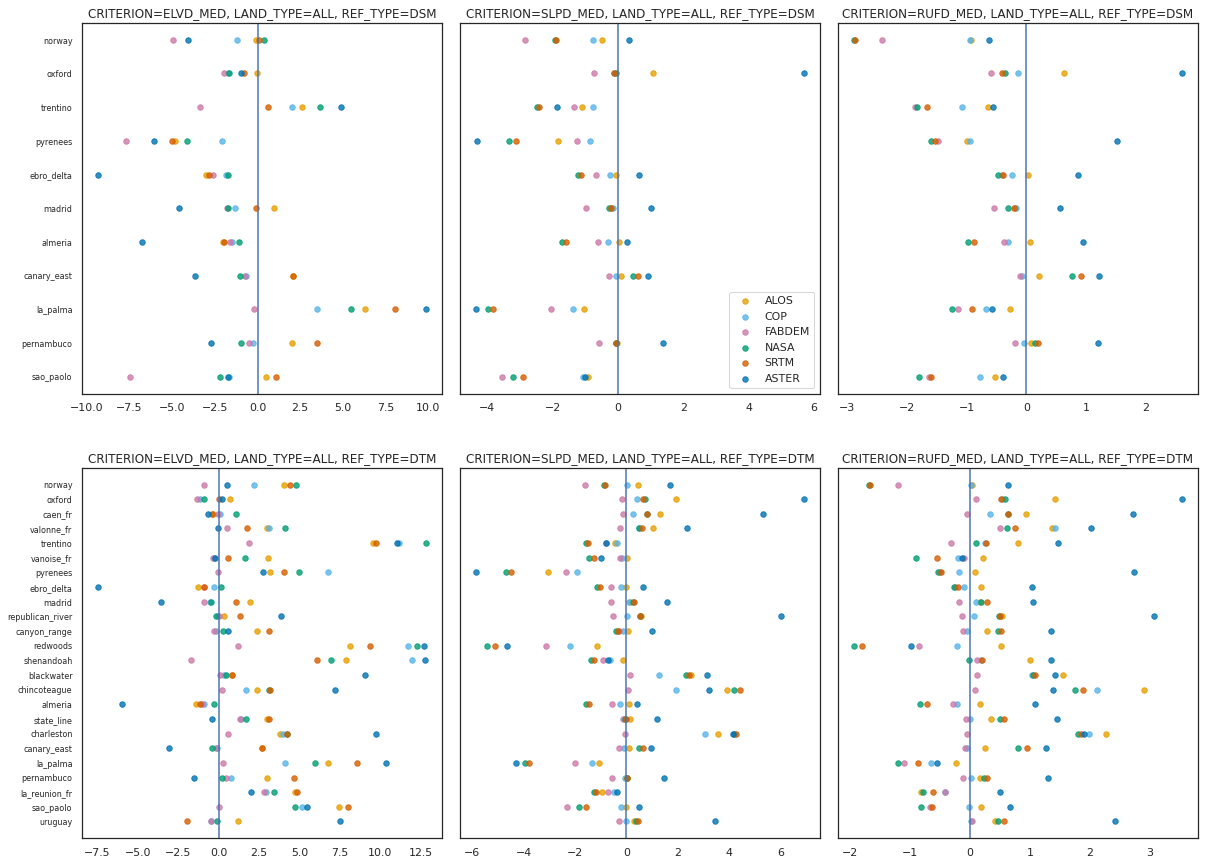

In [74]:
# MEDIANS
fname = 'medians_elev_slp_ruf_2023-06.svg'
ref_avg=ref_medians
plot_avgs(ref_avg, fname)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


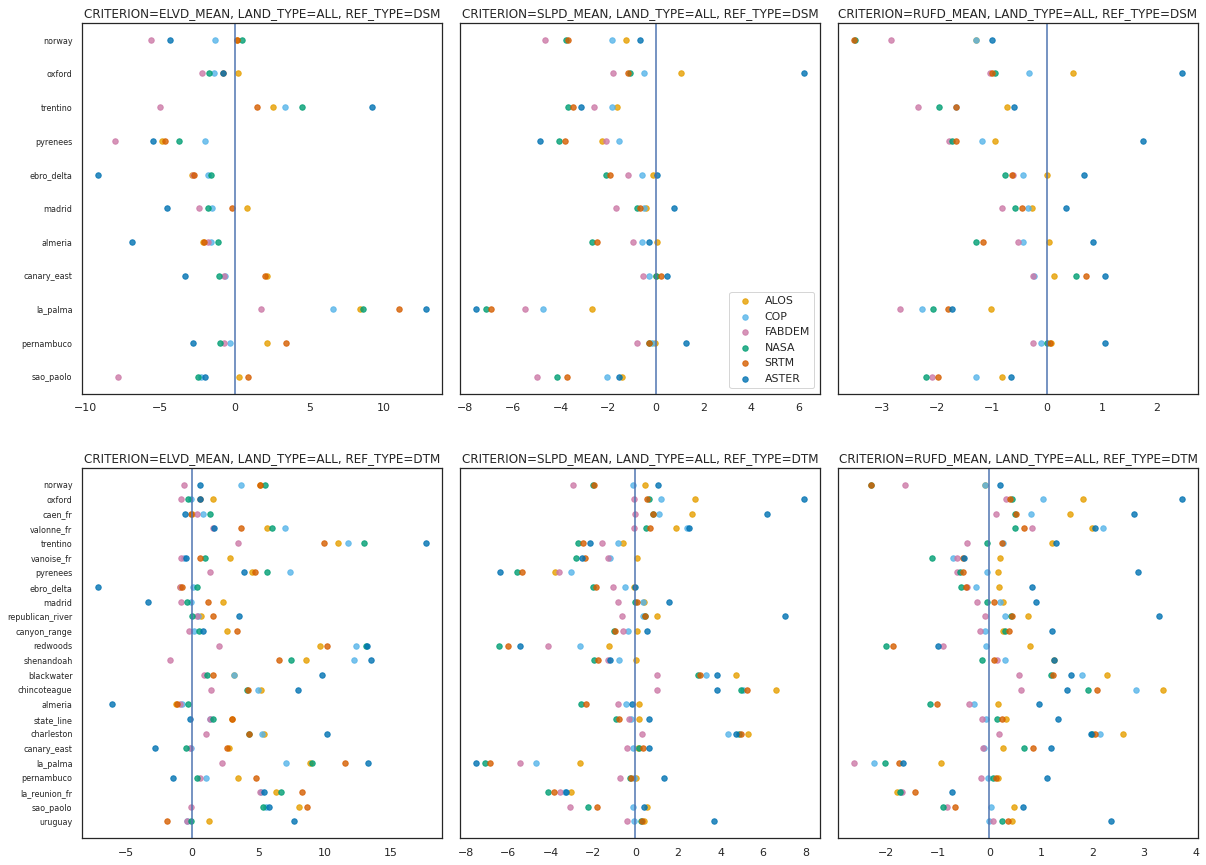

In [75]:
# MEANS (very similar to medians)
fname = 'means_elev_slp_ruf_2023-06.svg'
ref_avg = ref_means
plot_avgs(ref_avg, fname)


## Plot of unsigned criteria

In [59]:
# csv_file = 'demix_database_v1.csv'
# csv_means = f'{root_dir}/{csv_file}'
# df = pd.read_csv(csv_means, sep=',',engine='python',comment='#',quotechar='"')
# df_sort = df.sort_values(by='AREA', key=lambda column: column.map(lambda e: tile_sort.index(e)))

crits = ['ELVD_RMSE','SLPD_MAE','RUFD_AVD']
ref_lst = ['DSM','DTM']
ref_crits = [(x,y) for x in ref_lst for y in crits]

In [65]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

def plot_unsigned(ref_crits, fname=False, norm=False):
    grid_kws = {'width_ratios': (0.3, 0.3, 0.3), 'wspace': 0.05} # size of subplots
    fig, axes = plt.subplots(2, 3, gridspec_kw=grid_kws,figsize=(20,15), sharey='row')
    # plot
    for i in range(6):
        ax = axes.flatten()[i]
        ref = ref_crits[i][0]
        crt = ref_crits[i][1]
        cond = f"REF_TYPE=='{ref}' and CRITERION=='{crt}'"
        title = f'CRITERION={crt}, LAND_TYPE=ALL, REF_TYPE={ref}'
        df_cond = df_sort.query(cond).copy().reset_index().reset_index()
        for dem in dem_order:
            y_seq = df_cond['index'][::-1]
            if norm:
                df_T = df_cond[dem_order].T
                for col in df_T.columns:
                    df_T[col] = min_max_scaling(df_T[col])
                df_TT = df_T.T
                x_dem = df_TT[dem]
            else:
                x_dem = df_cond[dem]
            ax.scatter(y=y_seq, x=x_dem, label=dem, marker='o', s=30, alpha=0.8, c=dem_clr_dict[dem])
        ax.set_title(title)
        ax.tick_params(axis='y', labelsize=8)
        area_list = list(df_cond['AREA'])
        area_unique = list(df_cond['AREA'].unique())[::-1]
        area_idxs = [dw.find_last(area_list,i) for i in area_unique]
        ax.set_yticks([i-1 for i in area_idxs][::-1])
        ax.set_yticklabels(area_unique)
        axes.flatten()[1].legend();
    # save fig
    if fname:
        plt.savefig(fname, dpi=300) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


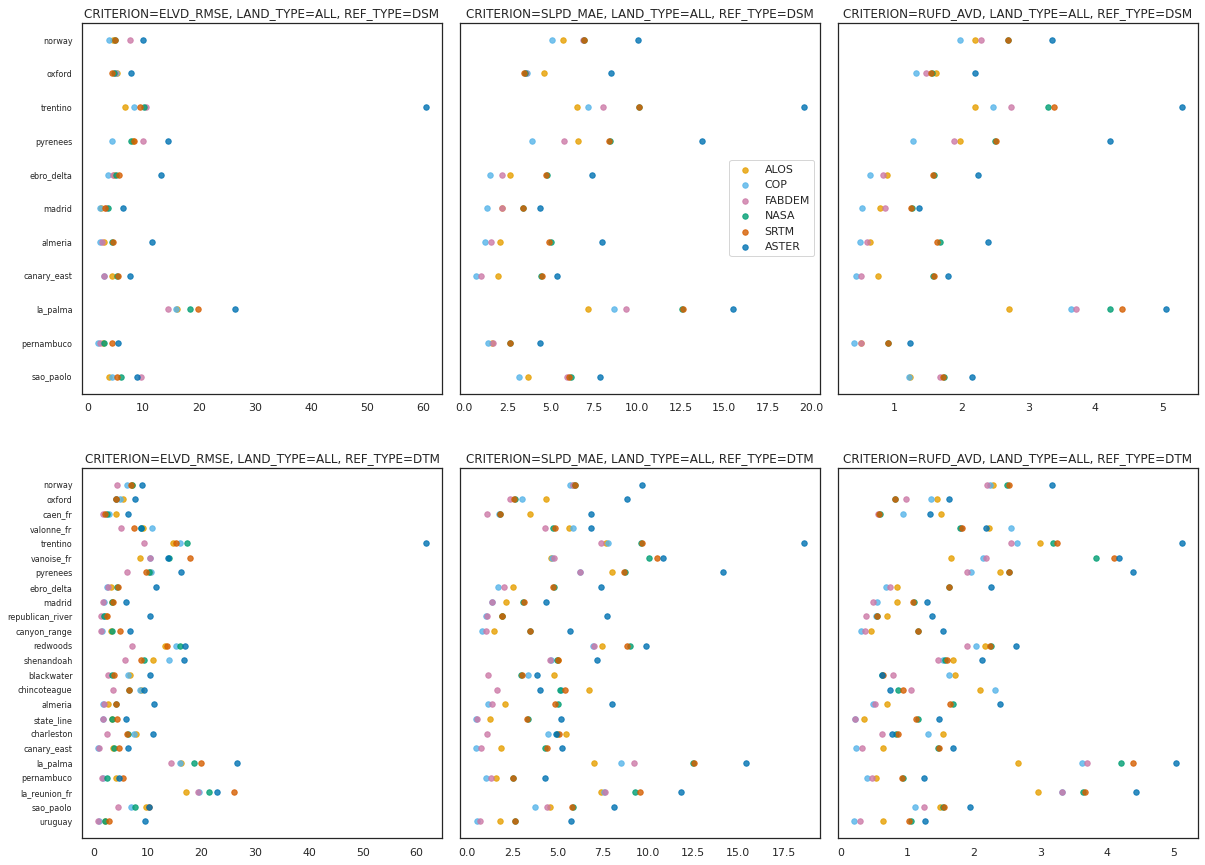

In [71]:
fname = 'plot_3tiles_unsigned_2023-06.svg'
plot_unsigned(ref_crits, fname, norm=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


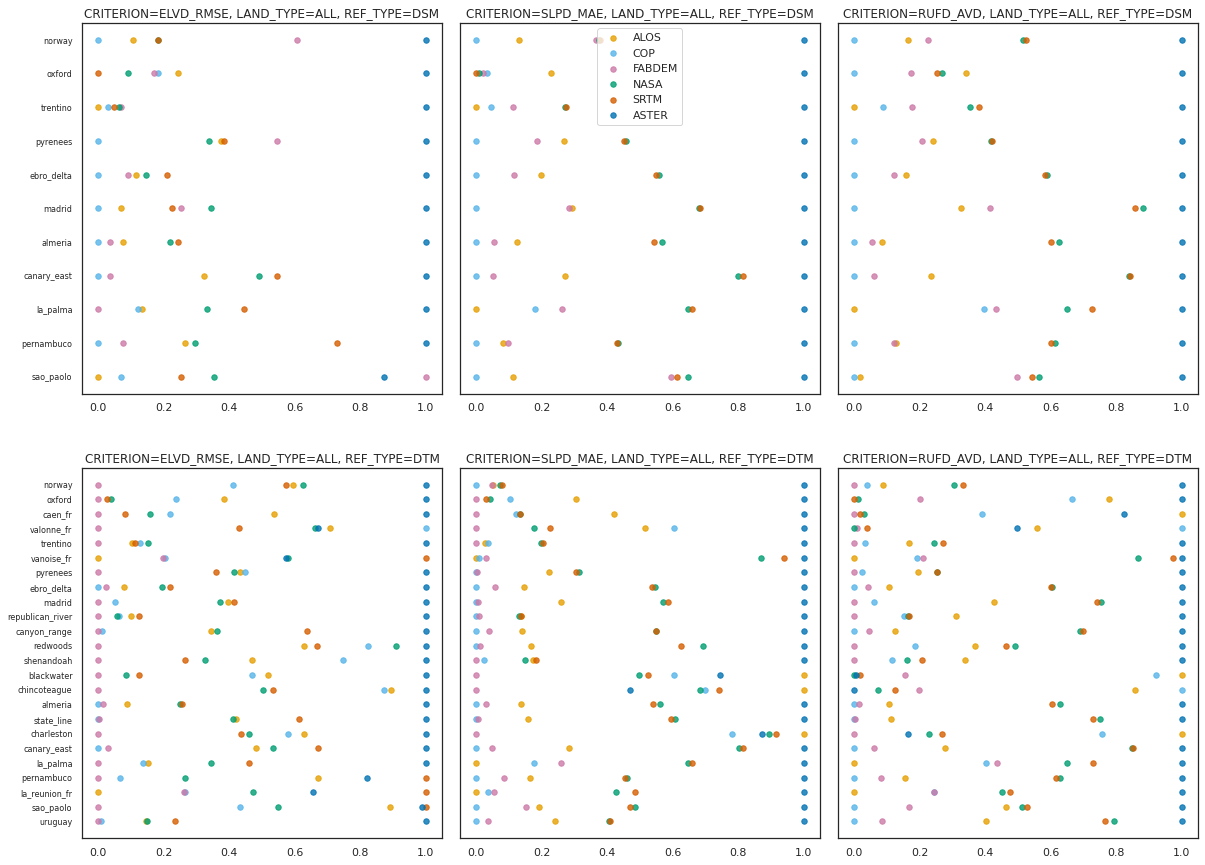

In [72]:
fname = 'plot_3tiles_unsigned_norm_0-1_2023-06.svg'
plot_unsigned(ref_crits, fname, norm=True)

## Plot of criteria for 3 tiles

In [97]:
csv = f'{root_dir}/{csv_file}'
df = pd.read_csv(csv, sep=',',engine='python',comment='#',quotechar='"')
df = df[['AREA','DEMIX_TILE','REF_TYPE','LAND_TYPE','CRITERION', 'FABDEM', 'COP', 'ALOS', 'NASA','SRTM', 'ASTER']]

ref_lst = ['DSM','DTM']
tiles_list = ['N28VW014B','N59TE009G','N43PW002B']
crit_list = df['CRITERION'].unique()

elv_crit = ['ELVD_MEAN','ELVD_MED','ELVD_AVD','ELVD_STD','ELVD_MAE','ELVD_RMSE','ELVD_LE90']
slp_crit = ['SLPD_MEAN','SLPD_MED','SLPD_AVD','SLPD_STD','SLPD_MAE','SLPD_RMSE','SLPD_LE90']
ruf_crit = ['RUFD_MEAN','RUFD_MED','RUFD_AVD','RUFD_STD','RUFD_MAE','RUFD_RMSE','RUFD_LE90']

elv_tiles = [(x,y) for x in tiles_list for y in elv_crit] 
slp_tiles = [(x,y) for x in tiles_list for y in slp_crit] 
ruf_tiles = [(x,y) for x in tiles_list for y in ruf_crit] 

In [98]:
df

,AREA,DEMIX_TILE,REF_TYPE,LAND_TYPE,CRITERION,FABDEM,COP,ALOS,NASA,SRTM,ASTER
0,canary_east,N28QW014A,DSM,ALL,ELVD_AVD,0.74,0.57,1.66,3.16,3.22,4.32
1,canary_east,N28QW014A,DSM,ALL,ELVD_STD,1.86,1.26,2.96,4.72,4.78,6.02
2,canary_east,N28QW014A,DSM,ALL,ELVD_RMSE,2.11,1.62,3.15,5.31,4.80,7.40
3,canary_east,N28QW014A,DSM,ALL,ELVD_MAE,1.26,1.14,2.04,3.65,3.28,6.10
4,canary_east,N28QW014A,DSM,ALL,ELVD_LE90,2.18,1.96,3.80,7.71,6.70,11.12
...,...,...,...,...,...,...,...,...,...,...,...
55694,uruguay,S31RW057F,DTM,BARREN,RUFD_RMSE,0.40,0.35,1.02,1.35,1.36,2.91
55695,uruguay,S31RW057F,DTM,BARREN,RUFD_MAE,0.27,0.18,0.72,1.08,1.09,2.55
55696,uruguay,S31RW057F,DTM,BARREN,RUFD_LE90,0.59,0.34,1.44,2.08,2.10,4.34
55697,uruguay,S31RW057F,DTM,BARREN,RUFD_MEAN,0.08,0.00,0.46,0.29,0.41,2.41


In [107]:
def plot_crit_3tiles(df, tiles_list, crit_list, fname):
    grid_kws = {'width_ratios': (0.3, 0.3, 0.3), 'wspace': 0.1} # size of subplots
    fig, axes = plt.subplots(2, 3, gridspec_kw=grid_kws,figsize=(20,8))#, sharey='row')
    #---------------------------------------
    # top row - DSM
    for i in range(3):
        ref = 'DSM'
        ax = axes.flatten()[i]
        tile = tiles_list[i]
        cond = f"DEMIX_TILE=='{tile}' and REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION in {crit_list}"
        title = f'TILE={tile}, LAND_TYPE=ALL, {ref}'
        df_cond = df.query(cond).copy()
        df_cond2 = df_cond.set_index('CRITERION').loc[crit_list].copy()
        for dem in dem_order:
            ax.plot(crit_list, df_cond2[dem], '-o', label=dem, c=dem_clr_dict[dem])
            ax.axhline(y=0)
            ax.set_title(title)
            ax.tick_params(labelsize=8)
    #---------------------------------------
    # bottom row - DTM
    for i in range(3,6):
        ref = 'DTM'
        ax = axes.flatten()[i]
        tile = tiles_list[i-3]
        cond = f"DEMIX_TILE=='{tile}' and REF_TYPE=='{ref}' and LAND_TYPE=='ALL' and CRITERION in {crit_list}"
        title = f'TILE={tile}, LAND_TYPE=ALL, {ref}'
        df_cond = df.query(cond).copy()
        df_cond2 = df_cond.set_index('CRITERION').loc[crit_list].copy()
        for dem in dem_order:
            ax.plot(crit_list, df_cond2[dem], '-o', label=dem, c=dem_clr_dict[dem])
            ax.axhline(y=0)
            ax.set_title(title)
            ax.tick_params(labelsize=8)
    # save fig
    plt.savefig(fname, dpi=300) 

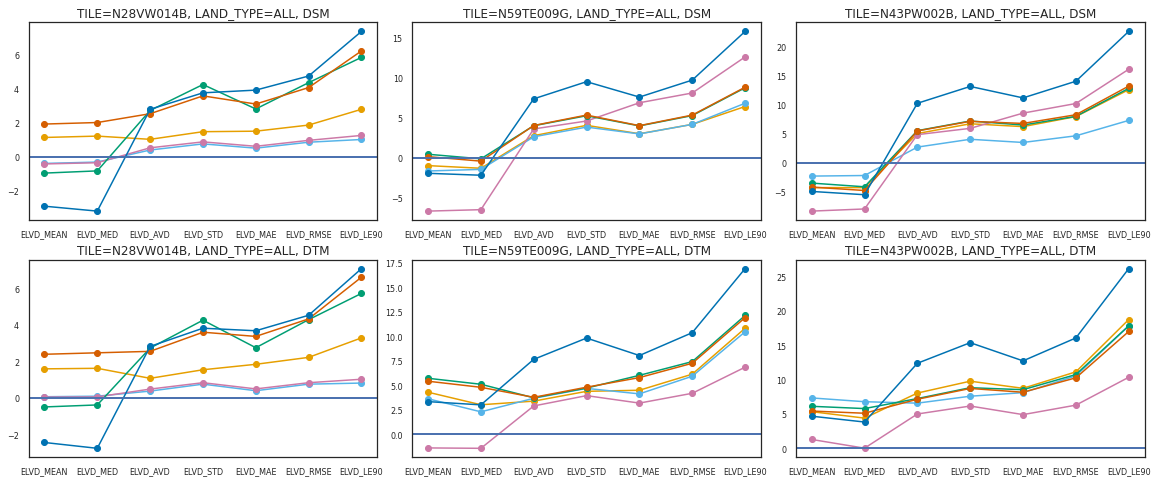

In [108]:
fname = '3tiles_elev_crits_2023-06.svg'
plot_crit_3tiles(df, tiles_list, crit_list=elv_crit, fname=fname)

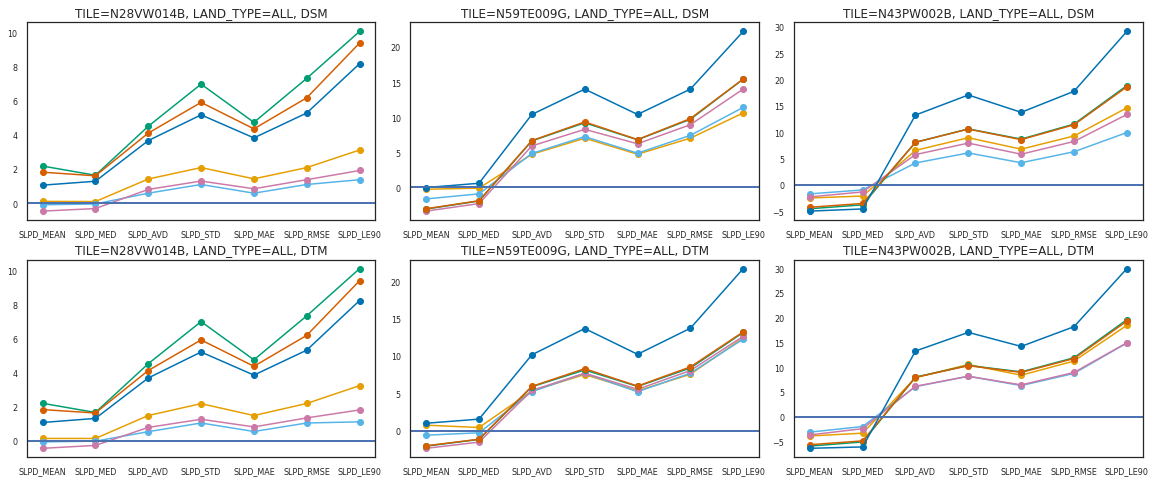

In [109]:
fname = '3tiles_slope_crits_2023-06.svg'
plot_crit_3tiles(df, tiles_list, crit_list=slp_crit, fname=fname)

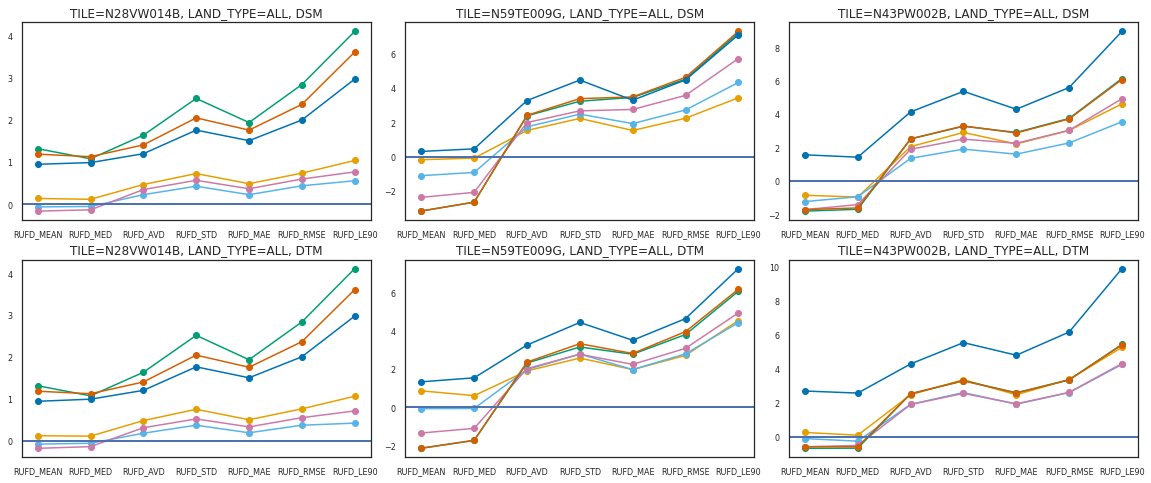

In [110]:
fname = '3tiles_rough_crits_2023-06.svg'
plot_crit_3tiles(df, tiles_list, crit_list=ruf_crit, fname=fname)

## Correlation Matrix

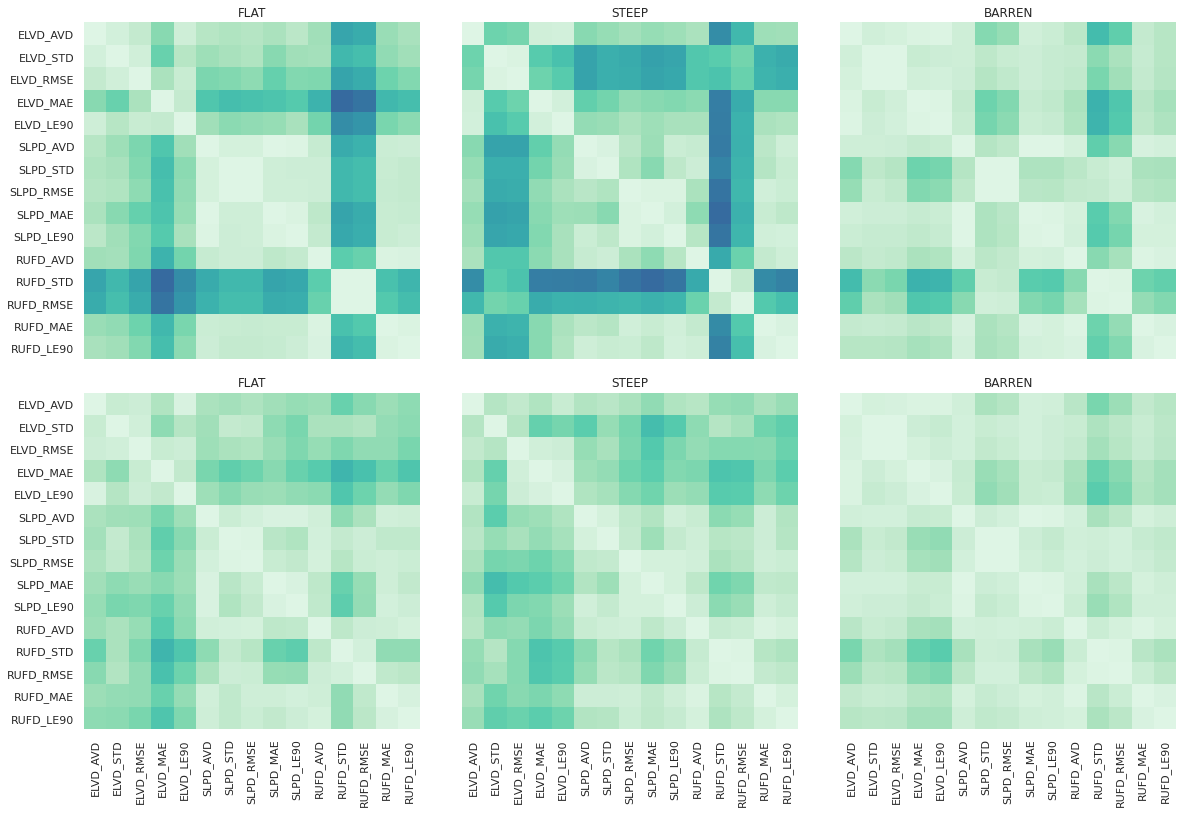

In [71]:
grid_kws = {'width_ratios': (0.3, 0.3, 0.3), 'wspace':0.05, 'hspace':0.1} # size of subplots
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,gridspec_kw=grid_kws,figsize=(20,13),sharey=True,sharex=True)

pvt_val = 'COP' # DEM used for this figure
ref_type = 'DSM'
ftype = 'svg'
cmap = 'mako'
# cmap = sns.color_palette("light:b_r", as_cmap=True)

# land_types = ['ALL','FLAT','GENTLE','STEEP','CLIFF']
# land_types = ['URBAN', 'FOREST','BARREN']
land_types = ['FLAT', 'STEEP','BARREN']
ax13 = [ax1,ax2,ax3]
for ax,land in zip(ax13,land_types):
    cond = f"REF_TYPE=='DSM' and LAND_TYPE=='{land}'" 
    df_pvt = dw.filter_by_cond_pivot_corr_matrx(df_criteria,cond,crit_order,pvt_val)
    corrMatrix = df_pvt.corr()
    s = sns.heatmap(corrMatrix,annot=False,ax=ax,vmin=0,vmax=1,annot_kws={'fontsize':10},
                    square=True,cmap=cmap,cbar=False)
    s.set_xlabel('')
    s.set_ylabel('')
    s.set_title(f'{land}')
    

ax46 = [ax4,ax5,ax6]
for ax,land in zip(ax46,land_types):
    cond = f"REF_TYPE=='DTM' and LAND_TYPE=='{land}'" 
    df_pvt = dw.filter_by_cond_pivot_corr_matrx(df_criteria,cond,crit_order,pvt_val)
    corrMatrix = df_pvt.corr()
    s = sns.heatmap(corrMatrix,annot=False,ax=ax,vmin=0,vmax=1,annot_kws={'fontsize':10},
                    square=True,cmap=cmap,cbar=False)
    s.set_xlabel('')
    s.set_ylabel('')
    s.set_title(f'{land}')
    
    
# fig.delaxes(ax6)        
# mappable = s.get_children()[0]
# plt.colorbar(mappable, ax=ax6)

plt.savefig(f'corr_matrix_{ref_type}_{cmap}_2023_06_lcover_dsm_dtm.{ftype}', dpi=300)